# Human Activity Recognition for Healthy Lifestyle Monitoring

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gallego, Pablo Herrero Ortiz

## 1. Introduction

This project implements a **Human Activity Recognition system** using smartphone sensor data to classify five common daily activities: sitting down, standing up, walking, running, and climbing stairs. The solution follows a complete pipeline, including:

1. **Data acquisition and preparation**: Raw accelerometer, gravitational and gyroscope signals are collected from smartphones for the different activities. Data is prepared into a suitable format for the notebook and later it is cleaned with preprocessing.  
2. **Feature engineering**: Deriving meaningful statistical and frequency-based features that capture movement patterns.  
3. **Learning methods**: Training and evaluating multiple supervised and unsupervised models.  
4. **Model comparison and analysis**: Comparing effectiveness of supervised and unsupervised approaches and identify optimal models amd features.  

The notebook is structured to reflect this workflow step by step. While it is divided into more detailed sections, they all contribute to the four stages defined above.  

### 1.1. Imports

To run this notebook, several libraries are needed. The code cell below gathers all required imports. 

**Required Installations:** Python (3.13.5), numpy (2.3.3), pandas (2.3.2), scipy (1.16.2), matplotlib (3.10.6), seaborn (0.13.2), scikit-learn (1.7.2), scikit-fuzzy (0.5.0)

*Note: Versions in previous list are those used for the execution. While older versions may still work, compatibility cannot be fully guaranteed.*

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.signal import butter, filtfilt
from scipy.stats import skew

import skfuzzy as fuzz

## 2. Data Acquisition

In this short section, the process from raw data obtention to the final dataset that is preprocessed is covered.

To measure, we have used continous recordings of 1 minute per activity, two times each. In the case of standing up and sitting down, two two-minute recordings were collected, during which the actions were alternated continuously. This way, all five activities have a similar total recording time.

Although further details can be consulted in the report, it is important to clarify that **the conversion of all raw data into a full merged csv has been done outside of this notebook**. For that purpose, data has been trimmed and labeled, introducing the columns `"label"` and `"session_id"`. Each session contains one continuous movement (which has just 1 action or 2 in the case of sitting/standing). Therefore, just regarding the 5 activities to be predicted, there is a total of 8 sessions.

Other columns include the timestamp, seconds elapsed since the start of the session, and 3 axis measurements for each sensor (gyroscope, accelerometer and gravitational). This makes a total of 13.

The last relevant factor is the `"still"` label. Many data points are assigned to this category, which means no action was being performed at the moment. While handling of those values is done later in the notebook, `"still"` is not part of the activities to be predicted.

In the following cell, the data path (constant) is defined and the dataframe obtained. There is also a short visualization of the first five rows to illustrate the format.

In [129]:
DATA_PATH = "../data/total_data.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,time,seconds_elapsed,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,grav_x,grav_y,grav_z,label,session_id
0,1757687344015902700,0.000000,0.077248,0.083397,-0.012479,0.095767,-0.045506,0.069702,0.607231,9.650743,1.632425,climbing_stairs,1
1,1757687344025856800,0.009954,0.083839,0.092482,-0.014544,0.050233,-0.035545,0.048986,0.608471,9.649460,1.639525,climbing_stairs,1
2,1757687344035810800,0.019908,0.089082,0.085130,-0.016256,0.004102,0.031565,0.053264,0.610609,9.648042,1.647068,climbing_stairs,1
3,1757687344045766000,0.029863,0.094225,0.070373,-0.022790,-0.003128,0.094264,0.050421,0.613201,9.646545,1.654849,climbing_stairs,1
4,1757687344055720000,0.039817,0.099883,0.054650,-0.029512,0.030005,0.131530,0.026595,0.616430,9.644893,1.663262,climbing_stairs,1


## 3. Preprocessing


This section focuses on preparing the raw sensor data for analysis and modeling. Several preprocessing steps are tested and applied to ensure data quality, comparability across sensors and robustness of the extracted features. The main objectives are to clean the data, handle inconsistencies, reduce noise, and prepare normalized input signals suitable for machine learning.

The process includes removing irrelevant classes, encoding categorical labels, visualizing raw signals, diagnosing possible issues, filtering some components and verifying the results through post-filtering visual checks. Further detail on how these actions are performed will be provided in their dedicated paragraphs.

There is no attenuation or amplification of signals, no decomposition and no need for synchronization (sensors are already synchronized).

### 3.1. Remove unwanted class and encode labels

First, the irrelevant `"still"` class is removed from the dataset, as it does not represent an activity to be predicted. 

After, the other activity labels are transformed from string into numeric values or integers using a `LabelEncoder`. This is done because most machine learning algorithms cannot directly handle categorical string labels.

In [130]:
df = df[df["label"] != "still"]

le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

print("Classes:", le.classes_)

Classes: ['climbing_stairs' 'running' 'sitting_down' 'standing_up' 'walking']


### 3.2. Raw visualizations

Before any further preprocessing, raw sensor signals across sessions are visualized to understand their behavior and detect potential irregularities. For this purpose, 3x3 subplots are used for each session individually. They contain one row per sensor (accelerometer, gyroscope, gravitational) and one column per axis (x, y, z). 

For sessions containing multiple activities (specifically sitting and standing), different colors are used to distinguish activity segments. A legend is displayed in these cases to provide clarity.

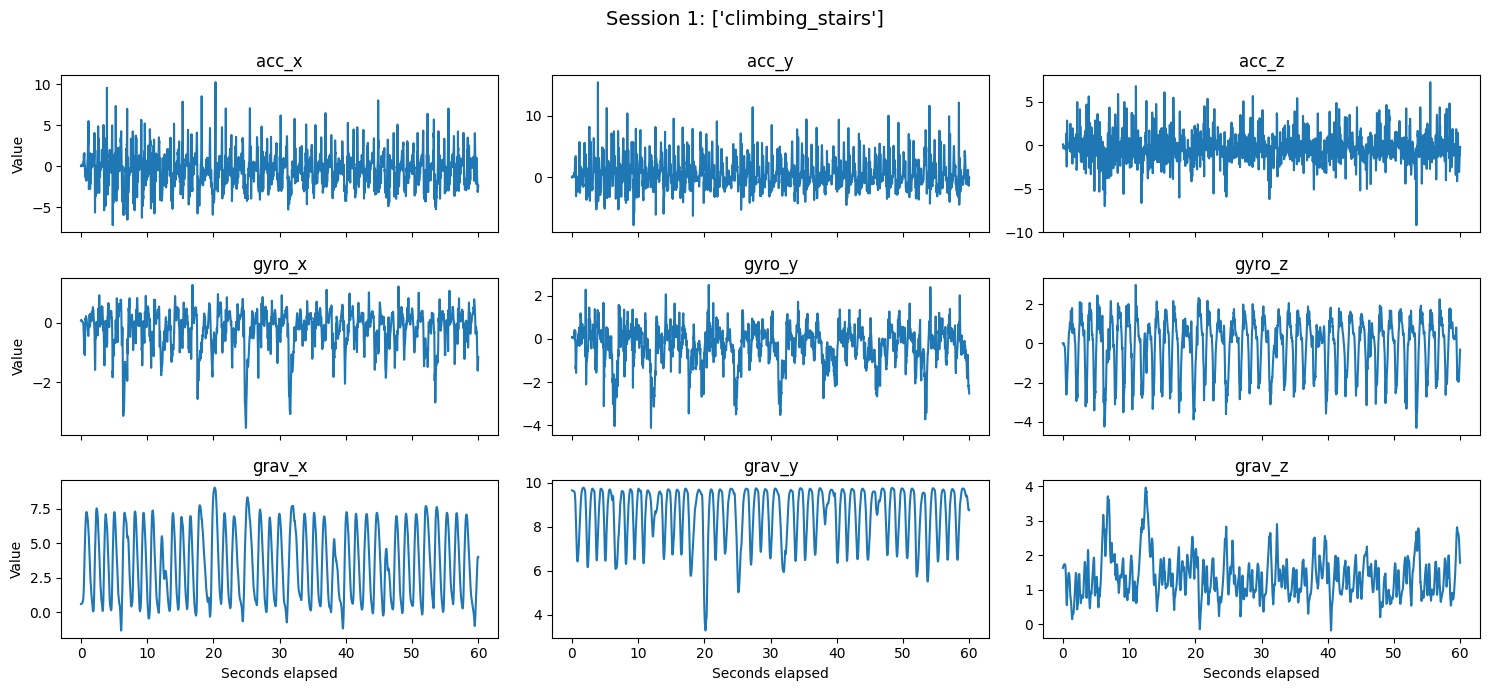

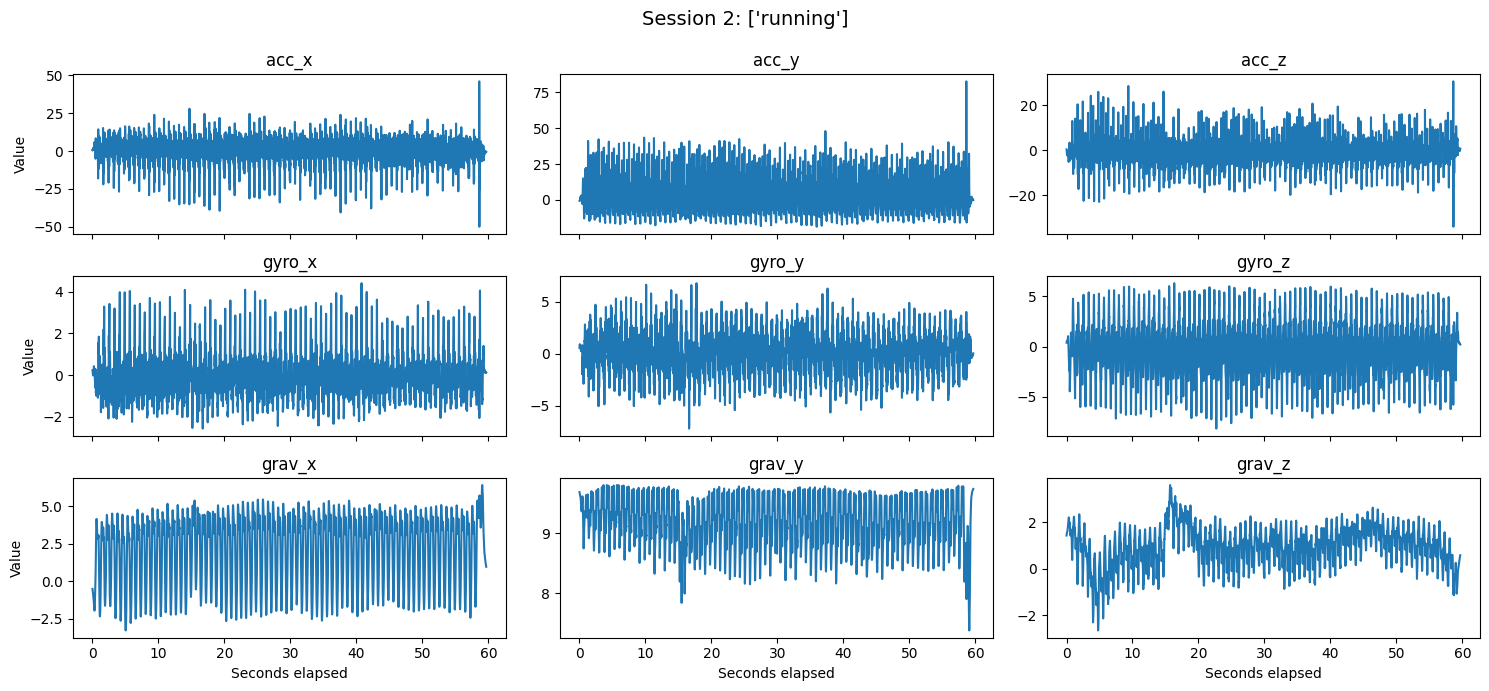

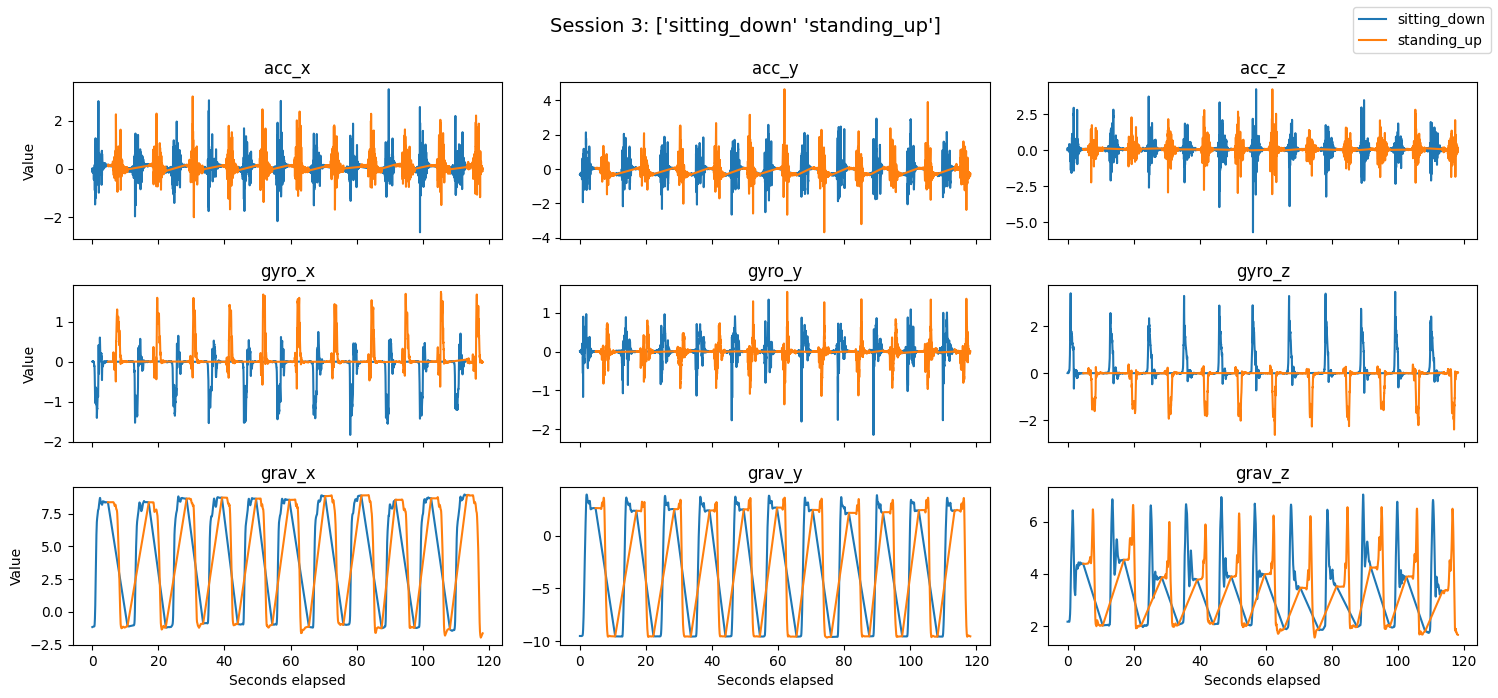

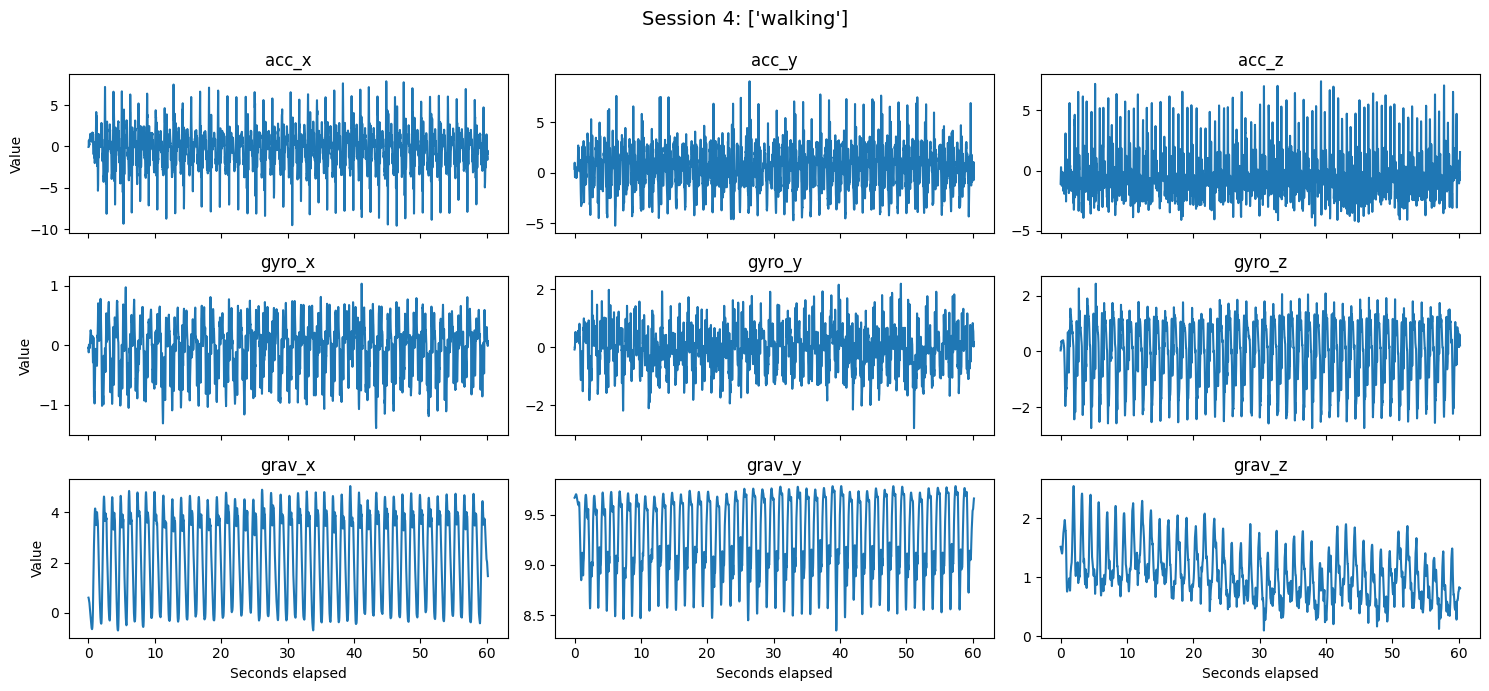

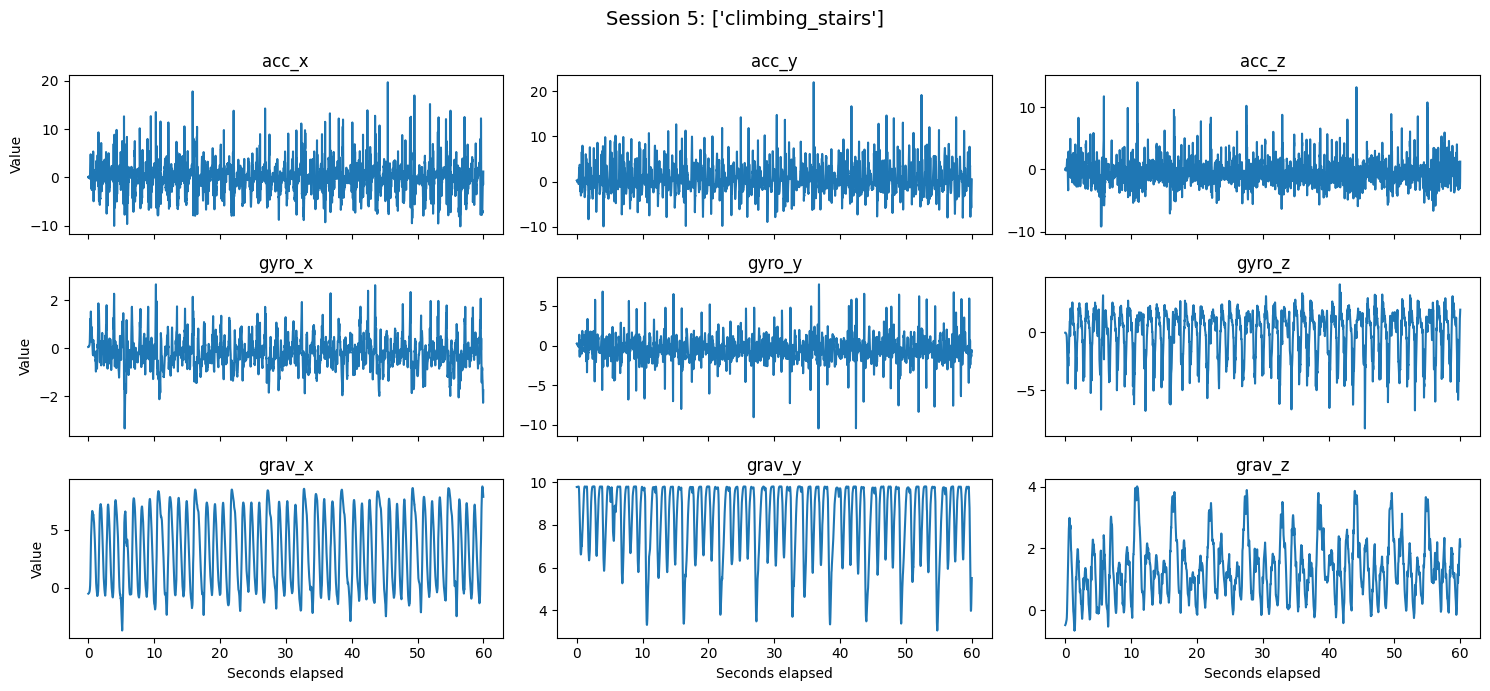

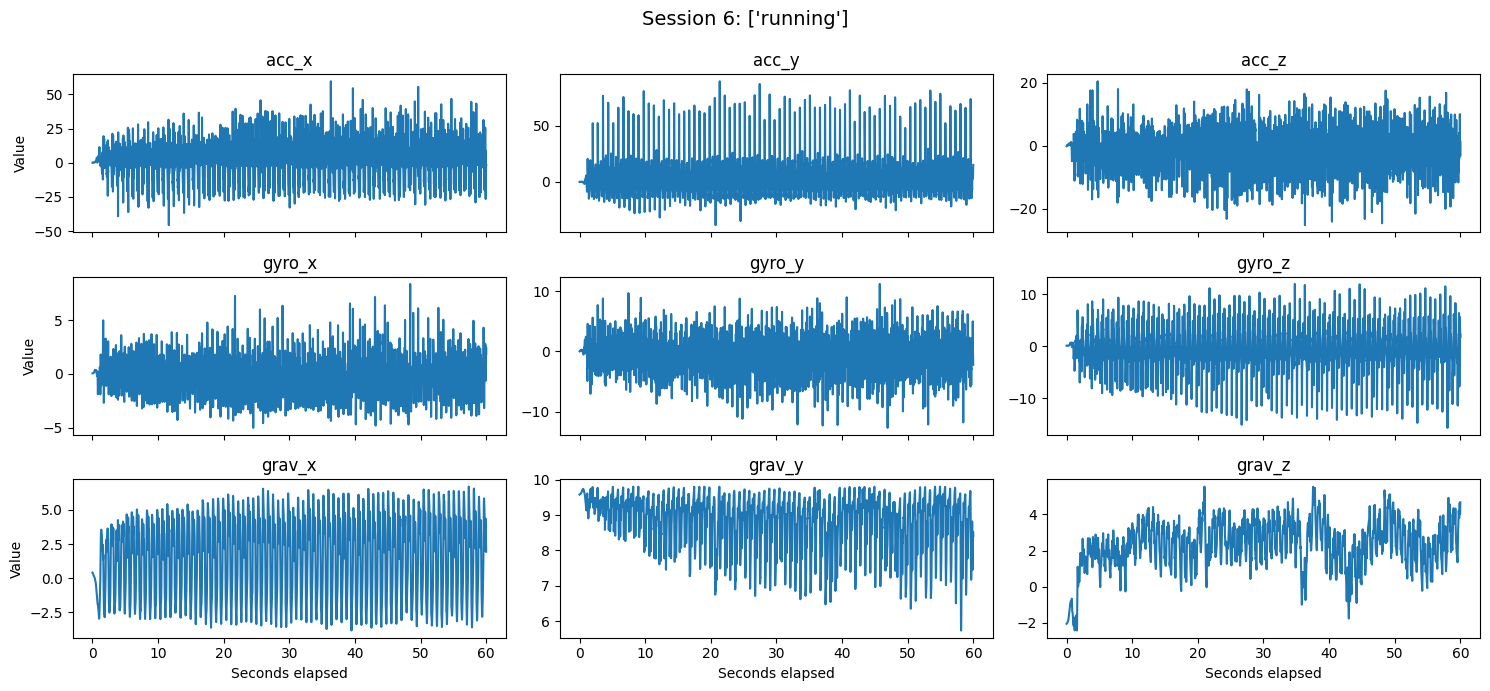

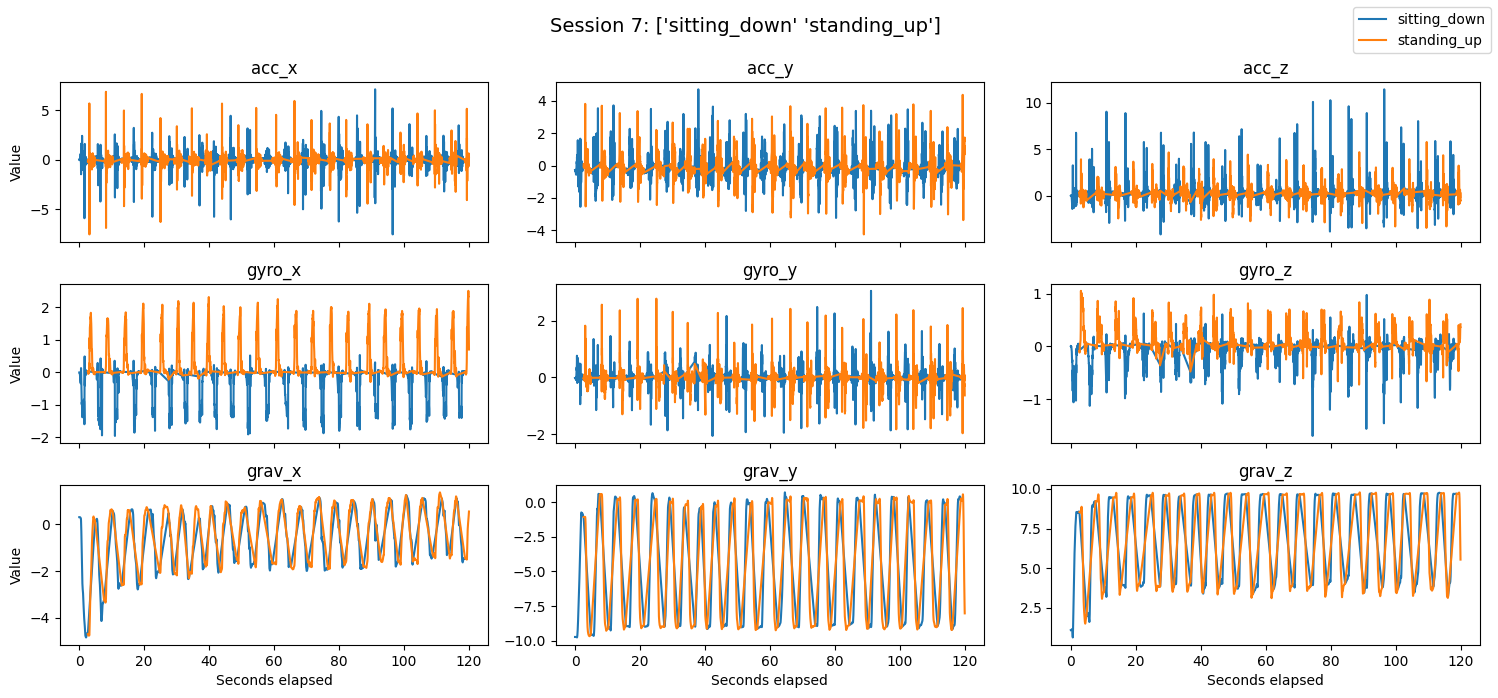

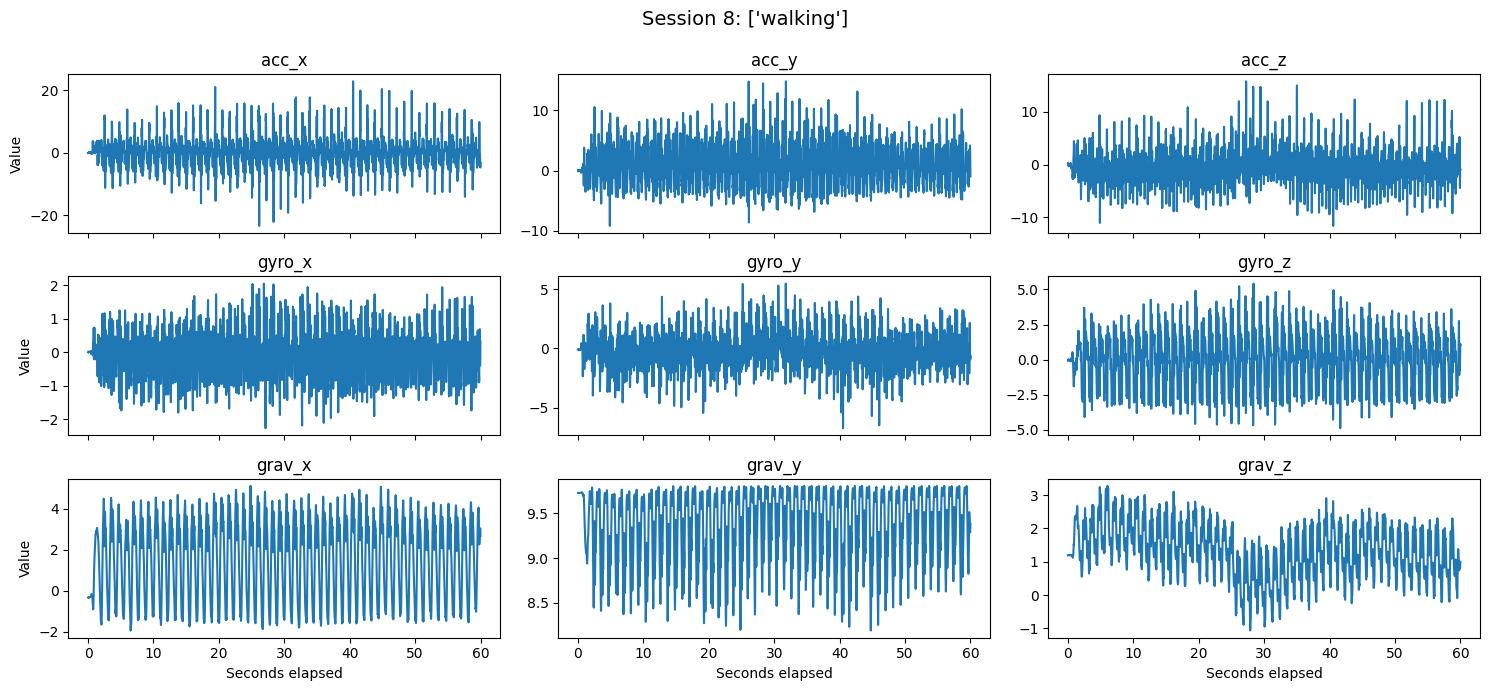

In [131]:
sensors = ["acc", "gyro", "grav"]
axes = ["x", "y", "z"]

for session_id in df["session_id"].unique():
    df_session = df[df["session_id"] == session_id]
    unique_labels = df_session["label"].unique()

    fig, axs = plt.subplots(3, 3, figsize=(15, 7), sharex=True)
    fig.suptitle(f"Session {session_id}: {df_session['label'].unique()}", fontsize=14)

    for i, sensor in enumerate(sensors):
        for j, axis in enumerate(axes):
            col = f"{sensor}_{axis}"
            ax = axs[i, j]

            # Plot each activity segment in a different color
            for label in unique_labels:
                subset = df_session[df_session["label"] == label]
                ax.plot(subset["seconds_elapsed"], subset[col], label=label)

            ax.set_title(col)
            if i == 2:
                ax.set_xlabel("Seconds elapsed")
            if j == 0:
                ax.set_ylabel("Value")

    if len(unique_labels) > 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

Overall, the plots show stable sensor variations across sessions, although some peaks and irregular movements can be seen. These observations justify performing diagnostic analyses and, if needed, filtering to reduce noise and stabilize signals.

### 3.3. Diagnostics

To assess data integrity, missing values are checked and the stability of the sampling frequency is verified. The diagnostics function has been designed to perform those actions in the following way:
- Missing values are checked by counting NaN entries per column, then (if there are any) shown in a print. 
- The time difference between samples is used to analyze frequency in each session. For the expected 100 Hz rate, `Δt` should average around 0.01 s, with minimal standard deviation indicating consistent timing. 

Additionally, the function can be asked to plot Fast Fourier Transforms for the selected measurements of any session. This can help analyze the frequency distribution of each sensor, taking into account that, for human motion information, most activity should lie below 15 Hz.

In [132]:
def diagnostics(df, fs=100, do_fft=False, fft_session=None, fft_measurements=None):
    """
    Run diagnostics on the dataset:
    - Sum of missing values per column
    - Δt stats per session, including the mean and standard deviation
    - Optionally: FFT for one session and selected measurements
    """

    # No missing values: missing_info is empty
    missing = df.isna().sum()
    missing_info = ', '.join([f"{col} = {val}" for col, val in missing.items() if val > 0])
    if missing_info:
        print(f"Missing values: {missing_info}")
    else:
        print("No missing values detected.")

    
    # For frequency: calculate seconds_elapsed continuity
    print("\nΔt metrics:")
    for session_id in df["session_id"].unique():
        df_sess = df[df["session_id"] == session_id]
        diffs = df_sess["seconds_elapsed"].diff().dropna()
        print(f"Session {session_id}: "
              f"mean Δt = {diffs.mean():.5f}s (expected ~{1/fs:.3f}s), "
              f"std = {diffs.std():.5f}s")
    
    # FFT
    if do_fft and fft_session is not None and fft_measurements is not None:
        df_sess = df[df["session_id"] == fft_session]
        n = len(df_sess)
        freqs = np.fft.rfftfreq(n, d=1/fs)

        cols = 3
        rows = int(np.ceil(len(fft_measurements) / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))

        for i, meas in enumerate(fft_measurements):
            r, c = divmod(i, cols)
            ax = axes[r, c] if rows > 1 else axes[c]
            fft_vals = np.abs(np.fft.rfft(df_sess[meas].values))
            ax.plot(freqs, fft_vals)
            ax.set_title(f"{meas}")
            ax.set_xlim(0, fs/2)
            ax.set_xlabel("Hz")
            ax.set_ylabel("Magnitude")

        plt.suptitle(f"FFT plots (Session {fft_session})", fontsize=14)
        plt.tight_layout()
        plt.show()

In the following cell, the extended diagnostics (with FFT for all sensors) for session 2 are demanded. The function call can be easily adapted to inspect other sessions if needed.

*Note: If the cell was to be re-run for a different session, it is relevant to check that the dataframe still contains raw data (no posterior preprocessing code cells have been executed before).*

No missing values detected.

Δt metrics:
Session 1: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s
Session 2: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s
Session 3: mean Δt = 0.00962s (expected ~0.010s), std = 0.00081s
Session 4: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s
Session 5: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s
Session 6: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s
Session 7: mean Δt = 0.00976s (expected ~0.010s), std = 0.00405s
Session 8: mean Δt = 0.00995s (expected ~0.010s), std = 0.00000s


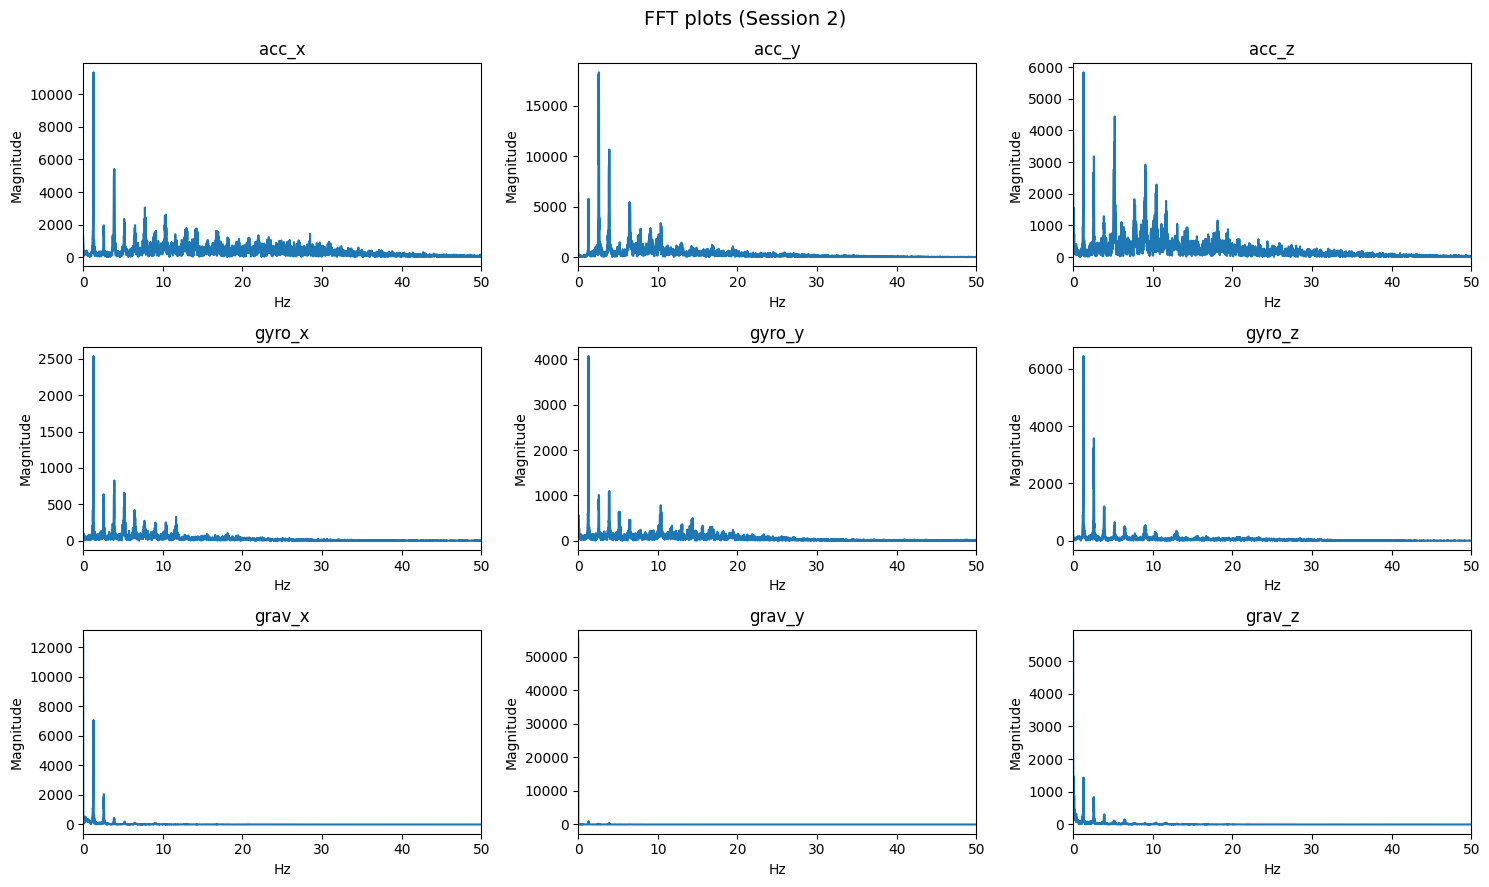

In [133]:
diagnostics(
    df,
    fs=100,
    do_fft=True,
    fft_session=2,
    fft_measurements=["acc_x", "acc_y", "acc_z",
                      "gyro_x", "gyro_y", "gyro_z",
                      "grav_x", "grav_y", "grav_z"]
)

As for missing values and sampling frequency, results demonstrate a perfect scenario:
- There are zero missing values, so there is no need for dropping or imputing any entries.
- The sampling frequency is highly stable, matching the expected 100 Hz.

The FFT diagrams, however, show some activity over the standard 15 Hz limit associated with human motion. This is specifically notable in `acc_x` and `acc_z` signals, and indicates that a low-pass filter could be useful to remove that high-frequency noise. Therefore, we proceed to filtering. 

### 3.4. Filtering

A 15 Hz low-pass filter is applied to the accelerometer and gyroscope channels to remove high-frequency noise unrelated to human movement.
Gravity sensor data are left unfiltered since they already capture the low-frequency component separately. The filtering was implemented through a custom `butter_filter()` function based on the Butterworth design.

A band-pass alternative (0.3–15 Hz) was considered for accelerometer data, but gravity is already handled explicitly and the low-pass filter offers a simpler and effective solution.

In [134]:
def butter_filter(data, cutoff, fs=100, order=4, btype="low"):
    """
    Apply Butterworth filter.
    cutoff : cutoff frequency in Hz
    fs     : sampling frequency (Hz), default 100
    order  : filter order
    btype  : 'low' for low-pass, 'high' for high-pass
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return filtfilt(b, a, data)

In [135]:
# Applied low-pass filtering to all accelerometer & gyroscope axis
for sensor in ["acc", "gyro"]:
    for axis in ["x", "y", "z"]:
        col = f"{sensor}_{axis}"
        df[col] = butter_filter(df[col], cutoff=15, btype="low")

### 3.5. Post-filter visualizations

After filtering, FFTs can be recalculated to verify that noise has been effectively reduced.
In the following code cell, the `plot_fft` function is defined to perform such task with any given session and measurement. The improvement is visually confirmed using the accelerometer’s x axis for the same session as before.

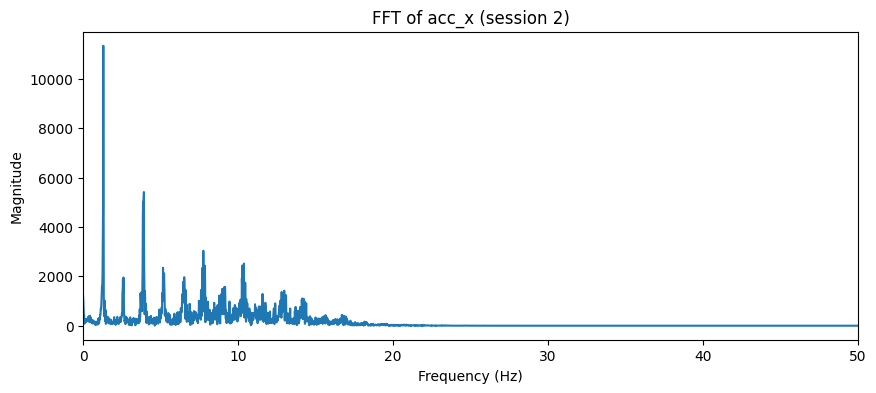

In [136]:
def plot_fft(signal, fs=100, title="FFT"):
    """
    Compute and plot the Fast Fourier Transform (FFT) of a signal.
    signal : array-like input signal to be transformed.
    fs : int or float, optional sampling frequency in Hz. Default is 100.
    title : str, optional title for the plot. Default is "FFT".
    """
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))

    plt.figure(figsize=(10,4))
    plt.plot(freqs, fft_vals)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 50)
    plt.show()

#  Plot accelerometer X in the same session as before
df_sess = df[df["session_id"] == 2]
plot_fft(df_sess["acc_x"].values, fs=100, title="FFT of acc_x (session 2)")

Finally, two violin plots are used to evaluate the separability of activity classes after preprocessing, showing some distinctions between motion patterns.

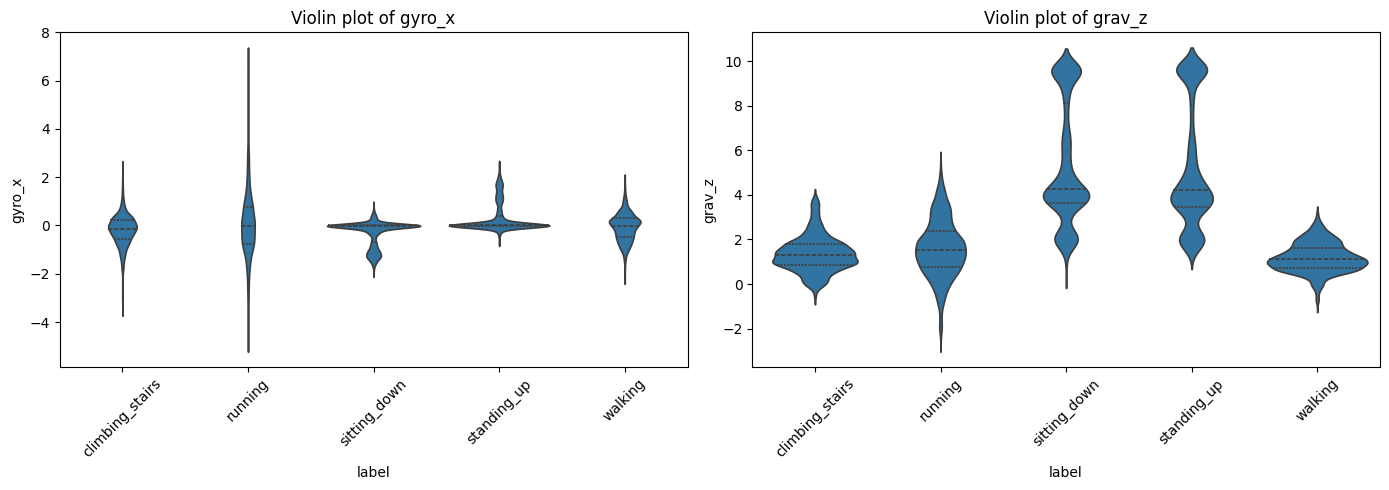

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)

sns.violinplot(data=df, x="label", y="gyro_x", inner="quartile", ax=axes[0])
axes[0].set_title("Violin plot of gyro_x")
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(data=df, x="label", y="grav_z", inner="quartile", ax=axes[1])
axes[1].set_title("Violin plot of grav_z")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

At this stage, the dataset is considered clean and ready for feature extraction and model training.

## 4. Feature Engineering and Extraction

In this section, the processed data is transformed into representative features suitable for machine learning. The process includes segmenting continuous recordings into smaller windows, computing statistical descriptors for each window and evaluating the relevance of those features through basic selection techniques like filter and wrapper methods. 

These steps are performed for the models to receive compact and informative inputs that capture the patterns of each activity.

### Previous preparation: Creating subtrials for each session

Before windowing, a new subtrial column is introduced to divide each session into smaller segments. This step helps avoid data leakage and simplifies the later window configuration. It is done primarily because of the two-activity sessions, which pose a challenge in terms of splitting in windows and separating into train and test data.

In those sessions that contain different consecutive activities, each activity segment is treated as an independent subtrial. On the other hand, for single-activity sessions, subtrials are defined using the average duration of the previous multi-action segments. This ensures a comparable structure for all sessions.

The first code cell performs a loop to calculate the average duration to be applied for the subtrials, and the second cell assigns subtrial IDs to every data point.

In [138]:
# Ensure chronological order within each session
df = df.sort_values(["session_id", "time"]).reset_index(drop=True)

transition_classes = ["sitting_down", "standing_up"]
transition_lengths = []

for session_id, df_sess in df.groupby("session_id", sort=False):
    labels = df_sess["label"].values
    # In indexes where activity changes, define boundaries
    change_idxs = np.where(labels[1:] != labels[:-1])[0] + 1
    boundaries = np.concatenate(([0], change_idxs, [len(labels)]))

    for i in range(len(boundaries) - 1):
        start, end = boundaries[i], boundaries[i + 1]
        label = df_sess.iloc[start]["label"]
        if label in transition_classes:
            transition_lengths.append(end - start)

# The avg duration of transitional actions is used to split continuous actions
target_len = int(np.mean(transition_lengths))
print(f"Average duration of short actions: {target_len} samples")

Average duration of short actions: 361 samples


In [139]:
subtrial_ids = []

for session_id, df_sess in df.groupby("session_id", sort=False):
    labels = df_sess["label_encoded"].values
    change_idxs = np.where(labels[1:] != labels[:-1])[0] + 1
    boundaries = np.concatenate(([0], change_idxs, [len(labels)]))
    sub_ids_sess = np.zeros(len(df_sess), dtype=object)
    
    for i in range(len(boundaries)-1):
        start, end = boundaries[i], boundaries[i+1]
        label = df_sess.iloc[start]["label"]
        
        if label in transition_classes:
            # Transitionals have one subtrial per label change 
            sub_id = f"{session_id}_{i}"
            sub_ids_sess[start:end] = sub_id
        else:
            # Continuous actions have subtrials of size ~target_len
            n_samples = end - start
            n_blocks = int(np.ceil(n_samples / target_len))
            block_ids = (np.arange(n_samples) // target_len).astype(int)
            for b in range(n_blocks):
                mask = (block_ids == b)
                sub_id = f"{session_id}_{i}_block{b}"
                sub_ids_sess[start:end][mask] = sub_id
    
    subtrial_ids.extend(sub_ids_sess)

df["subtrial_id"] = subtrial_ids    # Append to dataset

### 4.1. Windowing and feature extraction

Each subtrial is segmented into overlapping windows from which statistical features are extracted. For every window, seven statistics are used: mean, standard deviation, minimum, maximum, median, skewness, and RMS. This, times each of the nine raw signals, results in a total of 63 features per window.

Regarding window sizes, lengths between 2 and 4 seconds were tested. Although 3.5 seconds yielded slightly better accuracy, it produced too few windows for reliable training. A final window size of 2.4 seconds was chosen to maintain a balance between resolution and data availability.

The step size is set to 50% overlap for continuous sessions (run, walk, climb stairs) and 75% overlap for transitional sessions (sitting and standing combined), generating sufficient windows for both cases. 

*Note: No overlap is applied between different subtrials, ensuring data independence for train/test splits.*

In [140]:
WINDOW_SIZE = 240       # 2.4 seconds at 100 Hz
STEP_CONT_FRAC = 0.5    # 50% overlap for continuous actions
STEP_TRANS_FRAC = 0.25  # 75% overlap for transitional actions
MIN_FRACTION = 0.8      # At least 80% of samples with same label per window
TRANSITION_LABELS = ("sitting_down", "standing_up")

In [141]:
def extract_features(df_subset,
                     window_size=WINDOW_SIZE,
                     step_cont_frac=STEP_CONT_FRAC,
                     step_trans_frac=STEP_TRANS_FRAC,
                     min_fraction=MIN_FRACTION):
    """
    Segment each subtrial into fixed-length overlapping windows, from which a set of statistics is extracted for every numeric signal.

    Parameters
    ----------
    df_subset : Input data containing all sessions and subtrials.
    window_size : Window length in samples.
    step_cont_frac : Fractional step size for continuous activities.
    step_trans_frac : Fractional step size for transitional activities.
    min_fraction : Minimum fraction of samples with the same label for a window to be valid.

    Returns
    -------
    X_feat : Feature matrix with one row per window and one column per feature.
    y_feat : Encoded label of the dominant activity in each window.
    groups : Group identifiers (subtrial IDs) for later cross-validation.
    """    

    features, labels, groups = [], [], []
    drop_cols = ["time","seconds_elapsed","label","session_id","label_encoded","subtrial_id"]

    for subtrial_id, df_sub in df_subset.groupby("subtrial_id", sort=False): # Loop per individual subtrial
        sub_labels = df_sub["label"].values
        maj_label_sub = pd.Series(sub_labels).mode()[0]
        is_transition = maj_label_sub in TRANSITION_LABELS

        # Adapt step size depending on the subtrial class
        step_size = max(1, int(window_size * (step_trans_frac if is_transition else step_cont_frac)))

        # Keep only numeric columns from sensors
        X_sub = df_sub.drop(columns=[c for c in drop_cols if c in df_sub.columns]).select_dtypes(include=[np.number])
        y_sub = df_sub["label_encoded"].values

        for start in range(0, len(X_sub) - window_size + 1, step_size): # Windows across subtrial
            end = start + window_size
            window = X_sub.iloc[start:end]
            window_labels = y_sub[start:end]

            # Skip windows with < min_fraction has same label
            majority_label = pd.Series(window_labels).mode()[0]
            if (window_labels == majority_label).mean() < min_fraction:
                continue

            feats = []
            for col in window.columns:
                vals = window[col].values.astype(float)
                feats.extend([
                    vals.mean(),
                    vals.std(),
                    vals.min(),
                    vals.max(),
                    np.median(vals),
                    skew(vals),
                    np.sqrt(np.mean(vals**2))  # RMS
                ])

            features.append(feats)
            labels.append(majority_label)
            groups.append(subtrial_id)

    X_feat = pd.DataFrame(features)
    y_feat = np.array(labels)
    groups = np.array(groups)
    return X_feat, y_feat, groups

In [142]:
X_feat, y_feat, groups = extract_features(df)

print("Feature matrix shape (Windows, Features):", X_feat.shape)
print("Labels window distribution:", np.bincount(y_feat))

Feature matrix shape (Windows, Features): (373, 63)
Labels window distribution: [66 65 87 89 66]


### 4.2. Feature relevance: Mutual Information and RFE

To understand which features contribute most to classification performance, feature relevance is explored in this section through Mutual Information and Recursive Feature Elimination analyses.

*Note: None of the following code cells (under 4.2.x sections) replace the formal feature selection step in the main pipeline. They are shown as a preview of model accuracy evolution with several features, helping to guide future choices for top-ranked features in the pipeline.*

#### 4.2.1. Scaling

Sensor measurements operate on different numeric ranges, so features are standardized to ensure all of them contribute equally during model training. This way, features with larger magnitudes will not dominate the model.

In [143]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

#### 4.2.2. Mutual Information (MI)

It is used as a filter method to evaluate each feature’s individual relationship with the target variable (class labels), independent of any specific model.

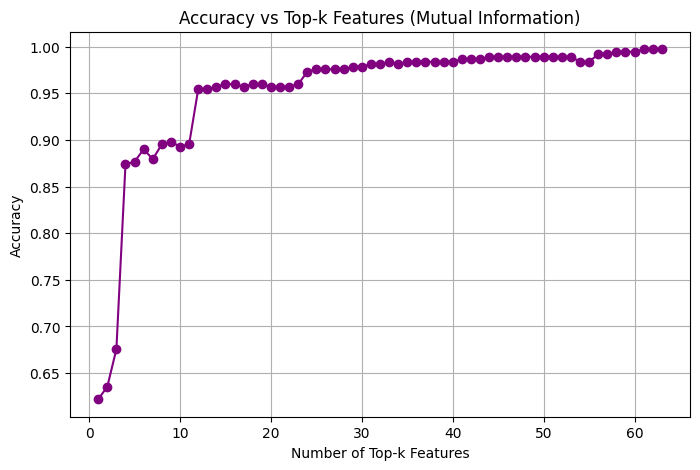

In [144]:
# MI scores for each feature
mi_scores = mutual_info_classif(X_scaled, y_feat, random_state=42)
feature_ranking = np.argsort(mi_scores)[::-1]

# Evaluate accuracy using the top-k ranked features
accuracy_list = []
for k in range(1, X_scaled.shape[1] + 1):
    top_k = feature_ranking[:k]
    model = LogisticRegression(max_iter=5000, solver="saga")
    model.fit(X_scaled[:, top_k], y_feat)   # Fitting on full data, just exploratory
    y_pred = model.predict(X_scaled[:, top_k])
    accuracy_list.append(accuracy_score(y_feat, y_pred))

plt.figure(figsize=(8,5))
plt.plot(range(1, X_scaled.shape[1] + 1), accuracy_list, marker="o", color="purple")
plt.xlabel("Number of Top-k Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Top-k Features (Mutual Information)")
plt.grid(True)
plt.show()

#### 4.2.3. Recursive Feature Elimination (RFE)

It is a wrapper method that iteratively trains a model (in this case Logistic Regression) and removes the least important features based on its performance.

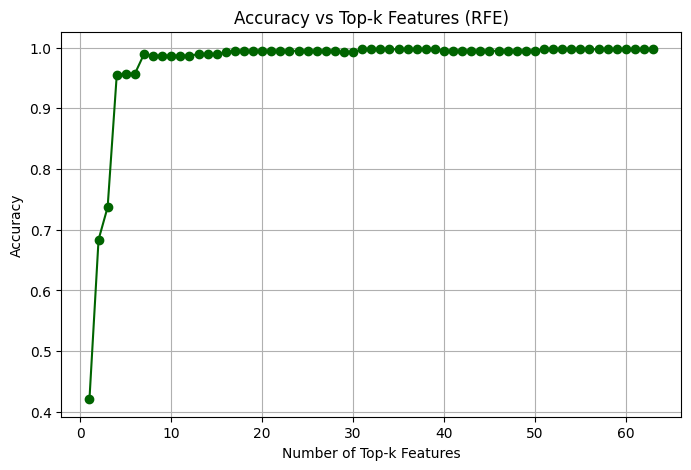

In [145]:
estimator = LogisticRegression(max_iter=5000, solver="saga")

# RFE ranks all features (1 = most important)
rfe = RFE(estimator, n_features_to_select=1, step=1)
rfe.fit(X_scaled, y_feat)
ranking = rfe.ranking_

# Evaluate accuracy as top-k features are incrementally added
feature_ranking_rfe = np.argsort(ranking)
accuracy_list_rfe = []
for k in range(1, X_scaled.shape[1] + 1):
    top_k = feature_ranking_rfe[:k]
    model = LogisticRegression(max_iter=5000, solver="saga")
    model.fit(X_scaled[:, top_k], y_feat)
    y_pred = model.predict(X_scaled[:, top_k])
    accuracy_list_rfe.append(accuracy_score(y_feat, y_pred))

plt.figure(figsize=(8,5))
plt.plot(range(1, X_scaled.shape[1] + 1), accuracy_list_rfe, marker="o", color="darkgreen")
plt.xlabel("Number of Top-k Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Top-k Features (RFE)")
plt.grid(True)
plt.show()

It is important to clarify that these analyses are performed on the entire dataset and serve only as an exploratory guide to understand feature relevance. The results of top-k features have not been interpreted as final feature selections for model training.

## 5. Cross Validation and Splitting

CV provides an estimate of model stability by training and testing across multiple folds, while a single train/test split simulates real deployment by holding out unseen data for final evaluation.


pipeline? 

- NORMALIZATION: Scaled with standardscaler because accelerometer and gyroscope values have different ranges, then training is easier.


### 5.1. Cross Validation

It is applied to evaluate model performance and stability. 

-----Text to modify----
Since each session typically contains only one activity, `GroupKFold` is not suitable (it would leave out unseen classes).  
Instead, we use `StratifiedKFold`, which ensures that each fold preserves the label distribution, giving a fair estimate of how well the models generalize across balanced splits.

In [146]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="saga"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier()
}

# CV by subtrial groups
cv = GroupKFold(n_splits=5)

print("Cross-validation results (F1-weighted, GroupKFold by subtrial):")
for name, clf in models.items():
    if name in ["Naive Bayes", "K Nearest Neighbours"]:
        rfe_estimator = LogisticRegression(max_iter=5000, solver="saga")
    else:
        rfe_estimator = clf

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mi", SelectKBest(mutual_info_classif, k=41)),  # tried different k for MI and n for RFE
        ("rfe", RFE(rfe_estimator, n_features_to_select=17, step=0.1)),
        ("clf", clf)
    ])

    scores = cross_val_score(
        pipe,
        X_feat, y_feat,
        cv=cv,
        groups=groups,
        scoring="f1_weighted"
    )

    print(f"{name:20s}: {scores.mean():.3f} ± {scores.std():.3f}")


Cross-validation results (F1-weighted, GroupKFold by subtrial):
Logistic Regression : 0.973 ± 0.014
Decision Tree       : 0.971 ± 0.027
Naive Bayes         : 0.976 ± 0.015
K Nearest Neighbours: 0.976 ± 0.022


The reported metric is **F1-weighted**, which balances precision and recall across all classes, taking class frequencies into account.  
This is more informative than accuracy when classes are not perfectly balanced.  
Results around 0.95 show that our statistical features provide strong discrimination between activities, with low variability across folds (± values), meaning the models are stable.

### 5.2. Splitting
After validating our features and models through cross-validation, we move to a supervised learning setup with a train/test split.  
This allows us to train a final model on the training set and evaluate it on a held-out test set, simulating performance on unseen data.

There is no overlap because it was defined that way in the features engineering. With StratifiedShuffleSplit and grouping by label we make each subtrial (and all its windows) go either into train or test. Each subtrial is a group, as defined in feature extraction.

In [147]:
# Each group has a majority label (all windows in a subtrial should have same label)
unique_groups = pd.DataFrame({
    "group": groups,
    "label": y_feat
}).drop_duplicates("group")

gss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_groups_idx, test_groups_idx = next(
    gss.split(unique_groups["group"], unique_groups["label"])
)

train_groups = set(unique_groups.iloc[train_groups_idx]["group"])
test_groups  = set(unique_groups.iloc[test_groups_idx]["group"])

train_idx = [i for i, g in enumerate(groups) if g in train_groups]
test_idx  = [i for i, g in enumerate(groups) if g in test_groups]

X_train, X_test = X_feat.iloc[train_idx], X_feat.iloc[test_idx]
y_train, y_test = y_feat[train_idx], y_feat[test_idx]

print("Train windows:", len(train_idx))
print("Test windows:", len(test_idx))
print("Train label window distribution:", np.bincount(y_train))
print("Test label window distribution:", np.bincount(y_test))

Train windows: 302
Test windows: 71
Train label window distribution: [53 52 68 77 52]
Test label window distribution: [13 13 19 12 14]


In [148]:
df_windows = pd.DataFrame({
    "label": y_feat,
    "group": groups
})

print("Total train groups:", len(train_groups))
print("Total test groups :", len(test_groups))
print("\nGroup counts (train):")
print(df_windows[df_windows["group"].isin(train_groups)]
    .drop_duplicates("group")["label"].value_counts()
    )
print("\nGroup counts (test):")
print(df_windows[df_windows["group"].isin(test_groups)]
    .drop_duplicates("group")["label"].value_counts()
    )

Total train groups: 126
Total test groups : 32

Group counts (train):
label
0    27
4    27
1    26
2    23
3    23
Name: count, dtype: int64

Group counts (test):
label
0    7
1    7
4    7
2    6
3    5
Name: count, dtype: int64


## 6. Supervised Learning

Here, we will train Logistic Regression, Decision Tree, Naive Bayes, and KNN on the training set and evaluate on the test set.   

### 6.1. Calculation and Summary of Metrics

Performance is reported using Accuracy, F1-weighted, and Cohen’s Kappa. The performance values for each case can be compared in the summary table. We use a pipeline similar to the one in Cross Validation. 

In [149]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver="saga"),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier()
}

results = {}

for name, clf in models.items():
    # Choosing an RFE estimator (LR if clf doesn’t have coef_/feature_importances_)
    if name in ["Naive Bayes", "K Nearest Neighbours"]:
        rfe_estimator = LogisticRegression(max_iter=5000, solver="saga")
    else:
        rfe_estimator = clf

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mi", SelectKBest(mutual_info_classif, k=41)),
        ("rfe", RFE(rfe_estimator, n_features_to_select=17, step=0.1)),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds, average="weighted"),
        "Kappa": cohen_kappa_score(y_test, preds),
        "Confusion": confusion_matrix(y_test, preds),
        "Report": classification_report(
            y_test, preds,
            target_names=le.classes_,
            output_dict=True
        )
    }
    
summary = pd.DataFrame({m: {k: round(v[k],3) for k in ["Accuracy","F1","Kappa"]} 
                        for m,v in results.items()}).T
print("Summary of metrics:")
display(summary)

Summary of metrics:


,Accuracy,F1,Kappa
Logistic Regression,0.958,0.958,0.947
Decision Tree,0.986,0.986,0.982
Naive Bayes,0.958,0.958,0.947
K Nearest Neighbours,0.958,0.958,0.947


#### Interpreting results  
- **Accuracy** shows the overall correctness, but can be misleading with imbalanced classes.  
- **F1-weighted** accounts for precision and recall per class, making it the main metric we focus on.  
- **Cohen’s Kappa** adjusts for chance agreement, confirming reliability beyond accuracy.  (1.0 = perfect agreement, 0 = random guessing)
- **Confusion matrices** reveal which activities are confused with each other. Normalized values make it easier to compare per-class performance independent of class frequency.

Interpretation: High accuracy, strong features (high F1). Kappa ≈ F1 → performance isn’t inflated by chance; the agreement is robust.

### 6.2. Absolute Confusion Matrixes

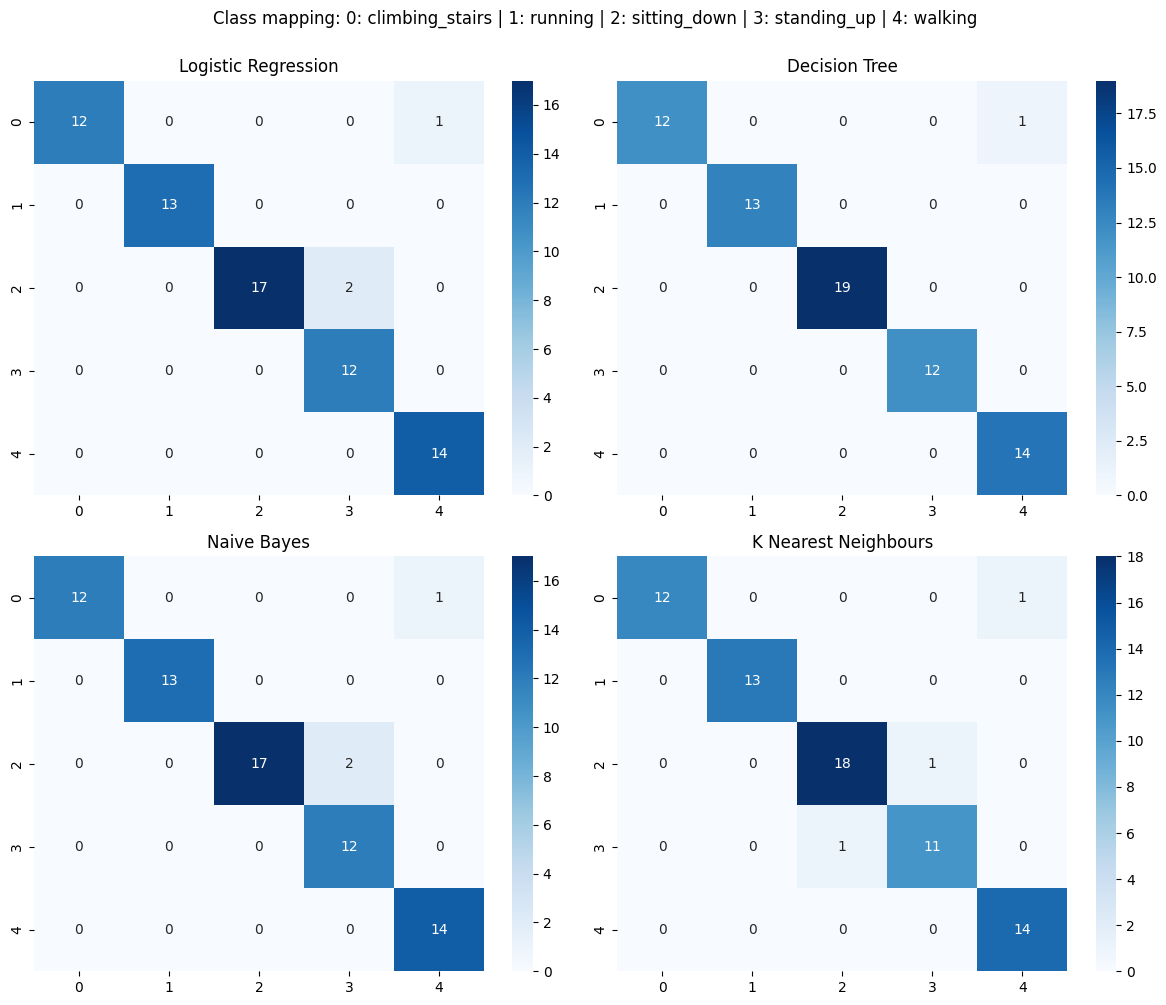

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    sns.heatmap(res["Confusion"], annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(f"{name}")

labels = " | ".join([f"{i}: {lab}" for i, lab in enumerate(le.classes_)])
fig.suptitle(f"Class mapping: {labels}", fontsize=12, y=1)

plt.tight_layout()
plt.show()

### 6.3. Normalized Confusion Matrixes

A more comprehensive view is given here, where the proportion of correctly and incorrectly predicted samples for each class and each method is shown.

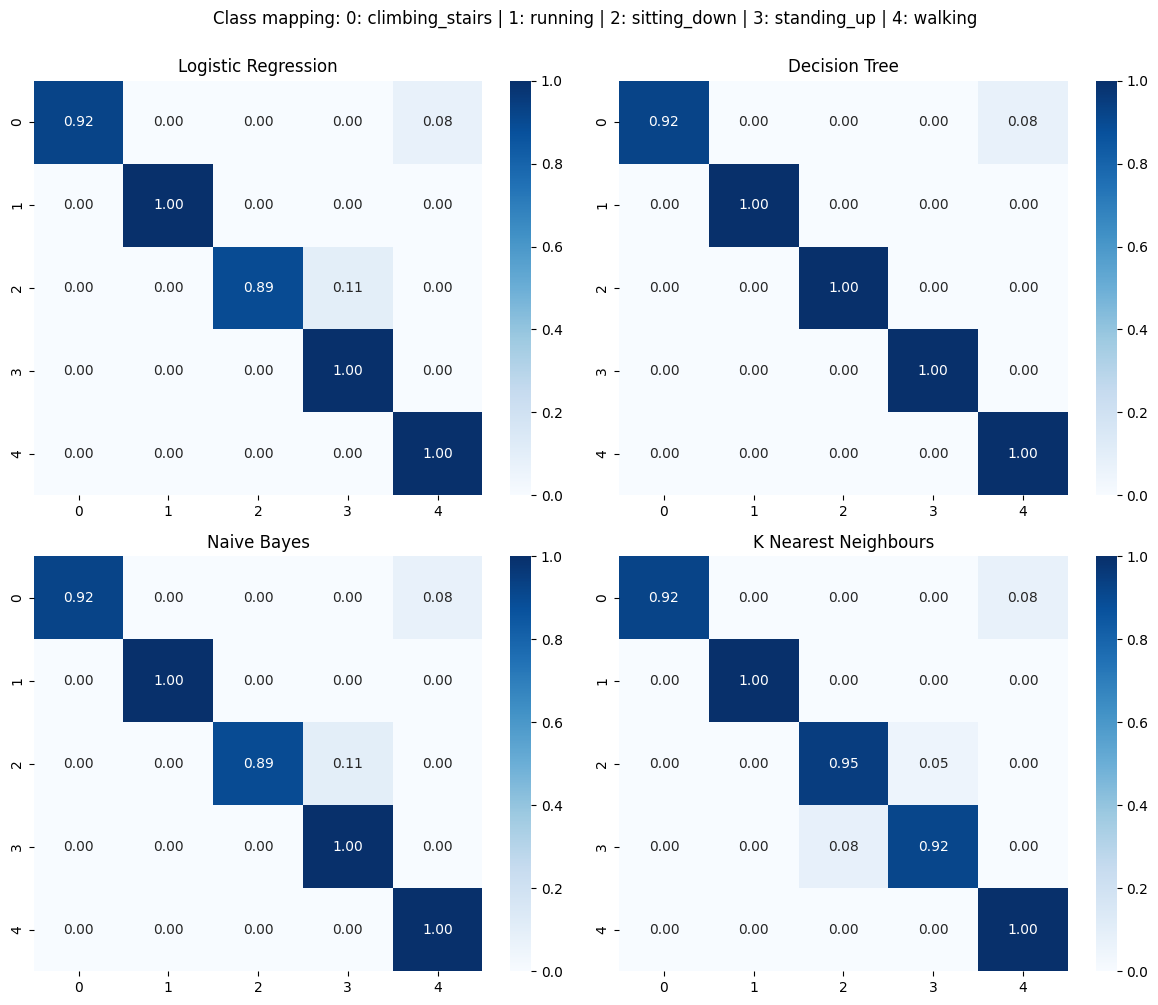

In [151]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for ax, (name, res) in zip(axes.flatten(), results.items()):
    cm_norm = res["Confusion"] / res["Confusion"].sum(axis=1)[:, None]
    sns.heatmap(cm_norm, annot=True, fmt=".2f", ax=ax, cmap="Blues")
    ax.set_title(f"{name}")

labels = " | ".join([f"{i}: {lab}" for i, lab in enumerate(le.classes_)])
fig.suptitle(f"Class mapping: {labels}", fontsize=12, y=1)

plt.tight_layout()
plt.show()

#### (Another) Results explanation

- Logistic regression benefits from scaling and well-engineered features. Implies that our features separate classes almost linearly. 

- Trees handle mixed features well. Single trees tend to overfit more easily than ensembles.

- Naive Bayes sometimes suffers when features are correlated. The high result means that the features are relatively independent and discriminative across classes. It can be luck too.

- KNN can struggle when classes overlap in feature space (walking vs. standing_up, both being moderate-intensity movements). When added scaling, results are improved significantly. Works well because nearby windows in feature space belong to the same activity.

## 7. Unsupervised Learning

In [152]:
# Scale features for clustering
scaler = StandardScaler()
X_scaled_uns = scaler.fit_transform(X_feat)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_uns)

# K-Means
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42).fit(X_scaled_uns)
kmeans_labels = kmeans.labels_

# Gaussian Mixture
gmm = GaussianMixture(n_components=len(le.classes_), random_state=42).fit(X_scaled_uns)
gmm_labels = gmm.predict(X_scaled_uns)

# Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled_uns.T, c=len(le.classes_), m=2, error=0.005, maxiter=1000, init=None)
fcm_labels = np.argmax(u, axis=0)

unsup_labels = {"KMeans": kmeans_labels, "GMM": gmm_labels, "FuzzyCMeans": fcm_labels}

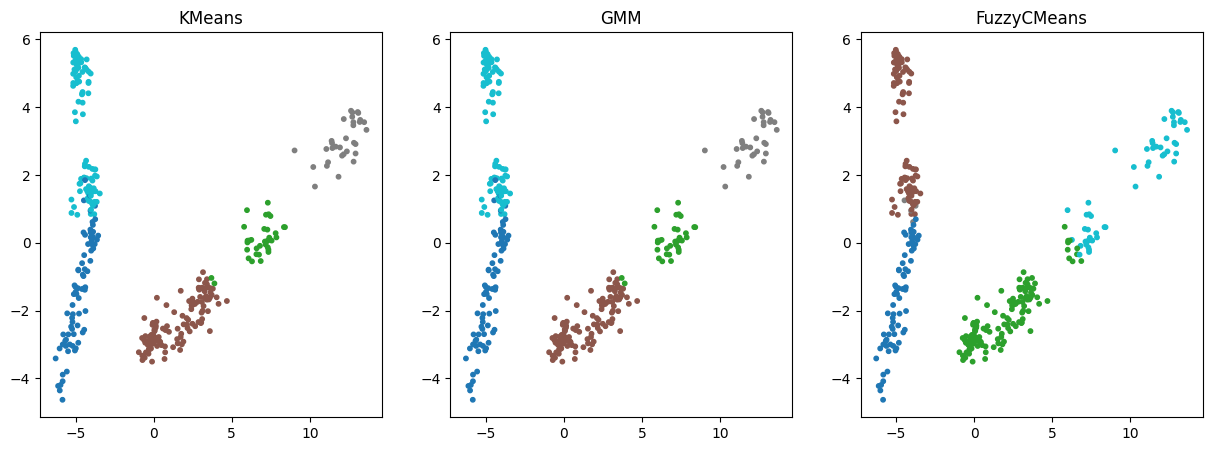

In [153]:
# Plot clustering results in PCA space
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax,(name, labels_) in zip(axes, unsup_labels.items()):
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_, cmap="tab10", s=10)
    ax.set_title(name)
plt.show()

In [154]:
for name, labels_ in unsup_labels.items():
    ari = adjusted_rand_score(y_feat, labels_)
    nmi = normalized_mutual_info_score(y_feat, labels_)
    sil = silhouette_score(X_feat, labels_)
    print(f"{name:12s} ARI={ari:.3f}, NMI={nmi:.3f}, Silhouette={sil:.3f}")


KMeans       ARI=0.456, NMI=0.656, Silhouette=0.541
GMM          ARI=0.456, NMI=0.656, Silhouette=0.541
FuzzyCMeans  ARI=0.449, NMI=0.627, Silhouette=0.324


Interpretation:
- ARI ~0.61 → clustering is moderately aligned with true labels (better than random, but not perfect).
- NMI ~0.73 → strong information overlap between clusters and true activities.
- Silhouette ~0.41 → clusters are reasonably compact and separated.
- KMeans and GMM performing equally well makes sense (both assume roughly spherical clusters).
- FCM worse → it’s more sensitive to initialization and fuzziness (membership overlap).

## 8. Model Comparison (not modified yet)

In [155]:
# Supervised comparison table
supervised_df = pd.DataFrame(results).T[["Accuracy","F1","Kappa"]]
print(supervised_df)

# Example unsupervised evaluation: Adjusted Rand Index vs true labels
from sklearn.metrics import adjusted_rand_score

unsup_scores = {name: adjusted_rand_score(y_feat, labels_) for name, labels_ in unsup_labels.items()}
unsup_scores

                      Accuracy        F1     Kappa
Logistic Regression   0.957746  0.958009  0.946949
Decision Tree         0.985915  0.985877  0.982254
Naive Bayes           0.957746  0.958009  0.946949
K Nearest Neighbours  0.957746  0.957708  0.946763


{'KMeans': 0.4562529942782453,
 'GMM': 0.4562529942782453,
 'FuzzyCMeans': 0.4489294110965336}

## Evaluation

In [156]:
# Identify best model
best_model = supervised_df["Accuracy"].idxmax()
print("Best performing supervised model:", best_model)

# Save summary
#supervised_df.to_csv("../data/supervised_results.csv")
#pd.DataFrame.from_dict(unsup_scores, orient="index", columns=["ARI"]).to_csv("../data/unsupervised_results.csv")

Best performing supervised model: Decision Tree
